## ATAC + MULTIOME GERM CELLS (april 2021)

### Build anndata from cellatac output 

In [2]:
# Load libraries
import pandas as pd 
import scanpy as sc
import numpy as np
import scipy.sparse

In [3]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/germcells_apr2021/"
experiment_prefix = 'germcells_'
cellatac_outdir = '/lustre/scratch117/cellgen/cellgeni/TIC-atacseq/tic-1005/germcells-work/results200k-b-germ/'


In [4]:
input={'cnts': cellatac_outdir + 'peak_matrix/peaks_bc_matrix.mmtx.gz',
        "bcs": cellatac_outdir + 'peak_matrix/bc.txt',
      "peaks": cellatac_outdir + 'peak_matrix/peaks.txt',
      'clusters': cellatac_outdir + 'qc/seurat-clades.tsv'}

output = {
    "cnt_mmtx":outdir + experiment_prefix + '_ATAC_cisTopic.mmtx',
    "cnt_peaks":outdir + experiment_prefix + '_ATAC_cisTopic.peaks.tsv',
    "cnt_cells":outdir + experiment_prefix + '_ATAC_cisTopic.cells.tsv',
    "h5ad":outdir + experiment_prefix + '_ATAC_raw.h5ad',
}

#### Make anndata object

In [5]:
adata = sc.read_mtx(input["cnts"]).T

bc = pd.read_table(input["bcs"], header=None)
feat = pd.read_table(input["peaks"], header=None)

adata.obs_names = bc[0]
adata.var_names = feat[0]

In [6]:
adata

AnnData object with n_obs × n_vars = 2020 × 127681

#### Load peak annotations (done with R script by Emma)

In [7]:
peak_anno_df = pd.read_csv(outdir + "ATACpeaks_annotation.csv", index_col=0)
peak_anno_df.index = peak_anno_df["peak_id"]
peak_anno_df.drop("peak_id",1, inplace=True)
adata.var = pd.concat([adata.var, peak_anno_df], 1)

#### Save binary data to layers

In [8]:
adata.layers["binary_raw"] = adata.X
adata.layers["binary_raw"][adata.layers["binary_raw"] > 1] = 1

#### Peak filtering

array([[<AxesSubplot:title={'center':'peak_width'}>]], dtype=object)

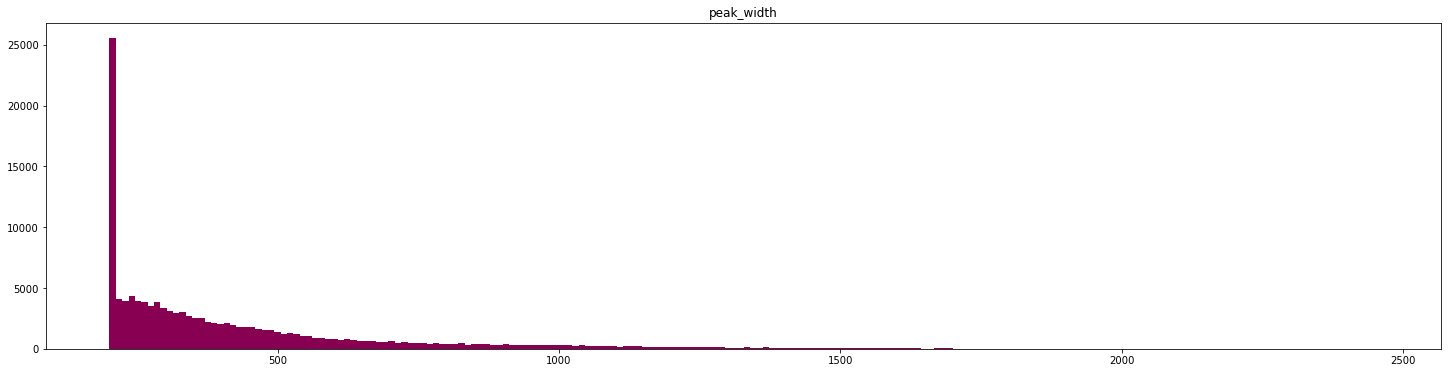

In [9]:
adata.var.hist(column = 'peak_width', bins = 200, grid = False, figsize = (25,6), color = '#870052')

In [10]:
var_qc = sc.pp.calculate_qc_metrics(adata, layer = "binary_raw")[1]
adata.var = pd.concat([adata.var, var_qc], 1)
adata

/opt/conda/envs/atac_env/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:316: UserWarning: Could not obtain multiprocessing lock due to OS level error: [Errno 28] No space left on device
A likely cause of this problem is '/dev/shm' is missing orread-only such that necessary semaphores cannot be written.
*** The responsibility of ensuring multiprocessing safe access to this initialization sequence/module import is deferred to the user! ***

  warnings.warn(msg % str(e))


AnnData object with n_obs × n_vars = 2020 × 127681
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [11]:
adata.var.head()

,peak_width,exon,gene,promoter,annotation,gene_name,gene_id,tss_distance,ENCODE_blacklist,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
chr1:10056-10444,389,0,0,0,intergenic,NaN,NaN,58646,1,56,0.027723,0.027345,97.227723,56.0,4.043051
chr1:180752-181621,870,0,0,1,promoter,FO538757.2,ENSG00000279928,771,1,746,0.369307,0.314305,63.069307,746.0,6.616065
chr1:191419-191619,201,0,1,0,intron,FO538757.1,ENSG00000279457,3791,1,21,0.010396,0.010342,98.960396,21.0,3.091043
chr1:263610-263810,201,0,0,0,intergenic,NaN,NaN,63287,1,9,0.004455,0.004446,99.554455,9.0,2.302585
chr1:267882-268082,201,0,0,0,intergenic,NaN,NaN,67559,1,34,0.016832,0.016692,98.316832,34.0,3.555348


array([[<AxesSubplot:title={'center':'total_counts'}>]], dtype=object)

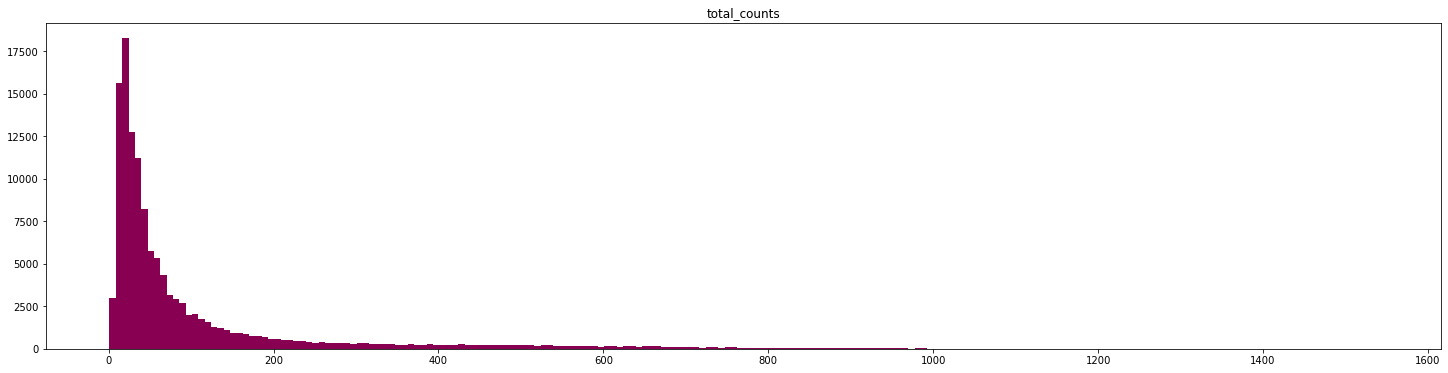

In [12]:
adata.var.hist(column = 'total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')

In [13]:
thirty_percent = len(adata.obs_names) / 100 * 30
point_two_percent = len(adata.obs_names) / 100 * 0.2
print("30% : {}".format(thirty_percent))
print("0.2% : {}".format(point_two_percent))

30% : 606.0
0.2% : 4.04


In [14]:
# Accessible in at least k cells
adata = adata[:,adata.var.total_counts > point_two_percent]
adata = adata[:,adata.var.total_counts < thirty_percent]
adata

View of AnnData object with n_obs × n_vars = 2020 × 123607
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [15]:
# Remove peaks in ENCODE blacklist
adata = adata[:, adata.var.ENCODE_blacklist == 0]
adata

View of AnnData object with n_obs × n_vars = 2020 × 122775
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [16]:
# Filter by width (remove peaks at the lowest end, closest to min peak width in MACS2)

adata = adata[:, adata.var.peak_width > 210]
adata = adata[:, adata.var.peak_width < 1500]
adata

View of AnnData object with n_obs × n_vars = 2020 × 98102
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [17]:
adata.var['annotation'].value_counts()

intergenic    39252
intron        33528
exon          21098
promoter       4224
Name: annotation, dtype: int64

In [19]:
### Filter peaks that are not accessible in at least 4% of cells from a coarse cluster
min_frac=0.04
# Load cluster information from cellatac outputs
clusters = pd.read_table(input["clusters"], header = None, index_col = 0)
clusters.columns = ["cellatac_clusters"]
adata.obs = clusters.loc[adata.obs_names]
adata

AnnData object with n_obs × n_vars = 2020 × 98102
    obs: 'cellatac_clusters'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [20]:
adata.obs.head()

,cellatac_clusters
01-ACAGAAAAGAGGAATG-1,4
01-ACTTTCAAGGGCTCTC-1,4
01-AGCCAGCAGGTGTCGA-1,4
01-CAGCTAATCTGGCGCA-1,1
01-GCACCTTGTTACGGAG-1,1


In [21]:
n_clusters = len(np.unique(adata.obs[["cellatac_clusters"]]))
clus_mat = np.empty([adata.n_obs, n_clusters])
for cl in np.unique(adata.obs[["cellatac_clusters"]]):
    clus_mat[np.where(adata.obs['cellatac_clusters']==cl)[0],cl] = 1

clus_mat = scipy.sparse.csr_matrix(clus_mat)
clus_mat[clus_mat != 1 ] = 0

/opt/conda/envs/atac_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3427: SparseEfficiencyWarning: Comparing a sparse matrix with a nonzero scalar using != is inefficient, try using == instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [22]:
cl_peak_mat = np.dot(clus_mat.T, adata.layers["binary_raw"])

In [23]:
cl_peak_frac = cl_peak_mat/clus_mat.sum(0).T

In [24]:
cl_peak_frac.max(0).shape

(1, 98102)

In [25]:
bool_matrix = cl_peak_frac.max(0) > min_frac
bool_matrix.shape

(1, 98102)

In [26]:
bool_vector = np.squeeze(np.asarray(bool_matrix))
bool_vector.shape

(98102,)

In [27]:
adata = adata[:, bool_vector]

In [28]:
adata

View of AnnData object with n_obs × n_vars = 2020 × 86770
    obs: 'cellatac_clusters'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

#### Filter low quality cells

In [29]:
sc.pp.calculate_qc_metrics(adata, layer = "binary_raw", inplace = True)

Trying to set attribute `.obs` of view, copying.


array([[<AxesSubplot:title={'center':'log1p_total_counts'}>]],
      dtype=object)

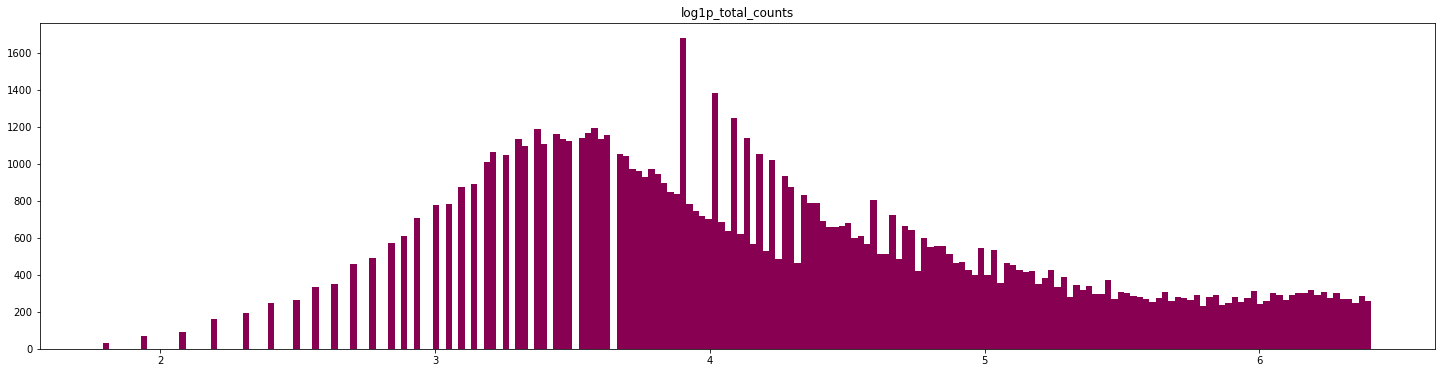

In [30]:
adata.var.hist(column = 'log1p_total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')

array([[<AxesSubplot:title={'center':'log1p_total_counts'}>]],
      dtype=object)

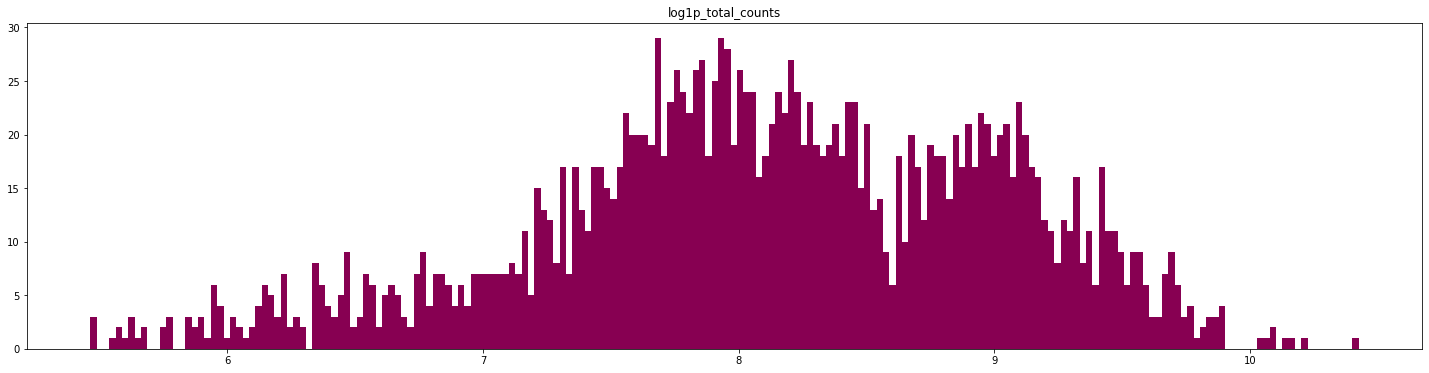

In [31]:
adata.obs.hist(column = 'log1p_total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')

In [32]:
adata = adata[adata.obs.log1p_total_counts >= 5.5]
adata

View of AnnData object with n_obs × n_vars = 2017 × 86770
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [33]:
## Write output anndata
adata.write_h5ad(output["h5ad"])

/opt/conda/envs/atac_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.var` of view, copying.
... storing 'annotation' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'gene_name' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'gene_id' as categorical


#### End of notebook